In [1]:
import numpy as np
import torch
import kagglehub
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.optim as optim
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.decomposition import TruncatedSVD
from torchmetrics.classification import MulticlassAccuracy, MulticlassConfusionMatrix
from torch.utils.data import TensorDataset, DataLoader
from gensim.models import Word2Vec

c:\Users\noams\anaconda3\envs\DeepLearningProjectNew\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Importing

text: a string feature representing the tweet.

label: a classification label with the following values:

0: sadness
1: joy
2: love
3: anger
4: fear
5: surprise

In [2]:
# Read the Parquet file
file_path = "train-00000-of-00001.parquet"  # Replace with your Parquet file path
df = pd.read_parquet(file_path)

# Inspect the DataFrame
df

,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2
...,...,...
416804,that was what i felt when i was finally accept...,1
416805,i take every day as it comes i m just focussin...,4
416806,i just suddenly feel that everything was fake,0
416807,im feeling more eager than ever to claw back w...,1


# Data Exploration

In [3]:
# Count samples for each label
label_counts = df['label'].value_counts()
print("Number of samples per label:")
print(label_counts)

Number of samples per label:
label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64


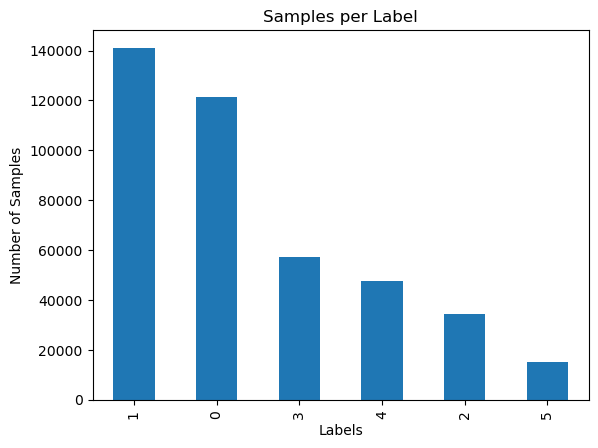

In [4]:
label_counts.plot(kind='bar')
plt.title("Samples per Label")
plt.xlabel("Labels")
plt.ylabel("Number of Samples")
plt.show()

In [5]:
# Determine the minority class size
minority_class_size = label_counts.min()
print(f"Minority class size: {minority_class_size}")

Minority class size: 14972


In [6]:
# Group by the category and sample the minority class size for each group
balanced_df = (
    df.groupby('label')
    .apply(lambda x: x.sample(n=minority_class_size, random_state=42))  # Randomly select samples
    .reset_index(drop=True)  # Reset the index
)

print("Class distribution after undersampling:")
print(balanced_df['label'].value_counts())

Class distribution after undersampling:
label
0    14972
1    14972
2    14972
3    14972
4    14972
5    14972
Name: count, dtype: int64


C:\Users\noams\AppData\Local\Temp\ipykernel_12596\1168985903.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('label')


In [7]:
balanced_df

,text,label
0,i feel sorry about you because your point of v...,0
1,i feel like he s watching quietly because he s...,0
2,i feel im ugly ugly ugly and ugly now,0
3,i remember my shower and the drawn out manner ...,0
4,i feel unwelcome when we can t go inside right...,0
...,...,...
89827,i feel amazing posted on a href http www,5
89828,i gotta feeling and oprah was not only shocked...,5
89829,i feel amazed as i watch these photos and foot...,5
89830,i am asked early in the morning through an int...,5


In [8]:
# Set pandas to display full text in columns
pd.set_option('display.max_colwidth', None)

balanced_df[balanced_df.label == 0]

,text,label
0,i feel sorry about you because your point of view is indoctrinated by these left wing european historical revisionists textbooks,0
1,i feel like he s watching quietly because he s resigned he s come to realize that people are going to die and there s nothing he can do about it,0
2,i feel im ugly ugly ugly and ugly now,0
3,i remember my shower and the drawn out manner in which i pressed my body up against the wall feeling a listless desperation in feigning the inability to support myself,0
4,i feel unwelcome when we can t go inside right away it hurts my feelings,0
...,...,...
14967,i was feeling throughly disillusioned with love i am currently still a hopeless hapless romantic img src http s,0
14968,i just need to sink into a hot bath wash the city grime out of my hair and skin and hope that the feeling returns to my abused legs by tomorrow well the dr did say that gentle exercise is essential for post dvt patients,0
14969,i feel like ive got a real handle on it like its an unpleasant thing that must be dealt with but life is otherwise so good that its more hassle than tragedy,0
14970,i just hate feeling helpless,0


In [9]:
balanced_df[balanced_df.label == 1]

,text,label
14972,i feel pretty talented,1
14973,i mean not much to feel obviously we have to look after ourselves and as i said i m very happy,1
14974,i feel excited and honored to have been given this opportunity by pulkit and ila,1
14975,to have a friend who i didnt see for months,1
14976,i was feeling stronger and fantastic,1
...,...,...
29939,i still wasn t feeling very sociable by the beginning of the week so remained a bit quiet and decided not to attend the skeptics in the pub debate on monday night,1
29940,i go i feel like i learn something very valuable and i also feel so much better in my body,1
29941,i feel contented and motivated to live like him,1
29942,i cant wait to stroll down the beach feeling comfortable with my body,1


In [10]:
balanced_df[balanced_df.label == 2]

,text,label
29944,i swore i could feel the cherishment in every gentle stroke,2
29945,i feel so devoted to my relationship and to myself which luckily go hand in hand for me,2
29946,i feel that if it was an image of someone doing something that they didnt want others to see such as the work of paul graham beyond caring i can see a reason why you would want something in return as these people are vunerable and run down while dicorcias heads image of mr,2
29947,i hover my pussy above his head just enough for me to feel the heat of his breath on my most tender parts and for him to smell my womanliness,2
29948,i was feeling horny sitting alone in the house,2
...,...,...
44911,i feel a tad more longing for my home my domain,2
44912,i feel the most passionate about for very personal reasons,2
44913,i cant really sleep on my back for long and i fidget around in bed because i feel so freakin hot imma burst into flames,2
44914,i dont think i should feel this way towards the person caring for my son,2


In [11]:
balanced_df[balanced_df.label == 3]

,text,label
44916,i feel irritated and i kinda hate this feeling,3
44917,id rather be home feeling violent and lonely im not trying to sound so insincere but the postcard thats taped to the freezer reads wish you were here how i wish i could disappear heads up,3
44918,i suggest you wait to discuss this with them until you re feeling less resentful,3
44919,i wrong to feel royally pissed off at all this,3
44920,im so tierd of talking about him like theres hope as if hell care to understand what it is i feel nikki tells me hes stubborn and just full of himself but whatever it may be it hurts because i feel so crappy,3
...,...,...
59883,i did notice less oil on my makeup free face at the end of the day though my skin didnt feel irritated or dry,3
59884,i feel cold hearted and maybe i am,3
59885,i feel a little physically irritable right now i decided i needed to share and then by doing so maybe i can take my mind off of how my body is feeling at least for a bit,3
59886,i start feeling annoyed and tired of it,3


In [12]:
balanced_df[balanced_df.label == 4]

,text,label
59888,i also am enjoying d a lot more now that i have gotten to know the majority of the people around me i don t feel pressured to make absolutely perfect work every time and can now just enjoy working and improving at my own pace,4
59889,i feel like i have restless leg syndrome this week,4
59890,i feel as though i am completely paranoid of everyone around me,4
59891,i was actually feeling the nervous nellies when i walked in because of that,4
59892,i feel vulnerable in so many situations but my weight no longer reflects that,4
...,...,...
74855,im fighting with myself it feels sometimes im scared,4
74856,im feeling very doubtful now,4
74857,i was feeling overly anxious and depressed towards the end of the ride monica would pick me up with the hint of i think that i might hear the highway through the trees or this stream looks very familiar,4
74858,i feel afraid or overwhelmed or completely out of my mind i turn to him my son the archer who has always seen his a href http www,4


In [13]:
balanced_df[balanced_df.label == 5]

,text,label
74860,i feel like a weird fish out of water listing to the little drummer boy while shopping for my halloween costume,5
74861,im terribly disappointed and yet i feel ludicrous saying so its a damn good excuse his father is having heart trouble may need repeat surgery,5
74862,i feel like ive entered some weird universe and i really am grateful for it,5
74863,i still want to feel amazed by a thunderstorm i still want to be inspired by the look of tiny droplets of rain on a spiders web i still want to feel the same way i do when a cold drop of rain hits my warm skin,5
74864,i feel impressed to share with that there are voices and vices of the enemy that we must identify and overthrow,5
...,...,...
89827,i feel amazing posted on a href http www,5
89828,i gotta feeling and oprah was not only shocked she was thrilled,5
89829,i feel amazed as i watch these photos and footage of this truly unique organism for i know that it might be the only opportunity so many of us will ever have to see something like it again,5
89830,i am asked early in the morning through an interview what brings me to krakow why and how i feel about my visit my impressions of the place and whether i am surprised that the poles have interest in hindi and hindi cinema,5


In [14]:
pd.reset_option('display.max_colwidth')

In [15]:
# Function to calculate word count
balanced_df['word_count'] = balanced_df['text'].apply(lambda x: len(str(x).split()))
balanced_df

,text,label,word_count
0,i feel sorry about you because your point of v...,0,20
1,i feel like he s watching quietly because he s...,0,31
2,i feel im ugly ugly ugly and ugly now,0,9
3,i remember my shower and the drawn out manner ...,0,30
4,i feel unwelcome when we can t go inside right...,0,15
...,...,...,...
89827,i feel amazing posted on a href http www,5,9
89828,i gotta feeling and oprah was not only shocked...,5,12
89829,i feel amazed as i watch these photos and foot...,5,38
89830,i am asked early in the morning through an int...,5,43


In [16]:
# Calculate statistics
min_words = balanced_df['word_count'].min()
max_words = balanced_df['word_count'].max()
avg_words = balanced_df['word_count'].mean()

print(f"Minimum words: {min_words}")
print(f"Maximum words: {max_words}")
print(f"Average words: {avg_words:.2f}")

Minimum words: 1
Maximum words: 100
Average words: 19.44


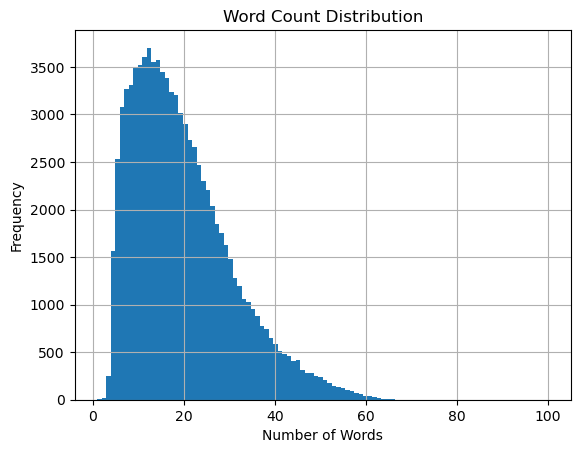

In [17]:
balanced_df['word_count'].hist(bins=100)
plt.title("Word Count Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

## Splitting Data To Fetures & Labels

In [18]:
# Create Bag of Words representation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(balanced_df['text'])  # Features
y = balanced_df['label']  # Labels

X

<89832x36275 sparse matrix of type '<class 'numpy.int64'>'
	with 1419944 stored elements in Compressed Sparse Row format>

In [19]:
print(X[74856].shape)
print(X[74856].sum())
## Words of 1 letter are ommitted from the sum?
X[74856].toarray()

(1, 36275)
5


array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [20]:
print(vectorizer.get_feature_names_out()[10:100])  # List (some) of words in the vocabulary

['aaron' 'aarons' 'aarthi' 'aate' 'aatp' 'ab' 'aback' 'abad' 'abandon'
 'abandoned' 'abandoning' 'abandonment' 'abashed' 'abate' 'abaya' 'abba'
 'abbasi' 'abbey' 'abbigail' 'abbott' 'abby' 'abc' 'abcesses' 'abd'
 'abdomen' 'abdominal' 'abduct' 'abducted' 'abdul' 'abe' 'abed' 'abefc'
 'abel' 'abercrombie' 'abhay' 'abhorr' 'abhorred' 'abhorrent' 'abi'
 'abide' 'abides' 'abiding' 'abigail' 'abililty' 'abilities' 'ability'
 'abilty' 'abit' 'abject' 'ablaze' 'able' 'ableness' 'ablity' 'ablo'
 'ably' 'abnormal' 'abnormality' 'abnormally' 'abo' 'aboard' 'abocs'
 'abode' 'abolish' 'abolitionist' 'abominable' 'aboriginal'
 'aboriginality' 'aboriginals' 'aborted' 'abortion' 'abotu' 'abou'
 'abound' 'abounding' 'abour' 'about' 'above' 'abq' 'abraham' 'abrahams'
 'abrams' 'abrasion' 'abrasive' 'abrathat' 'abroad' 'abrupt' 'abruptly'
 'abs' 'abscence' 'absence']


In [21]:
# Get the number of unique words
unique_words = len(vectorizer.vocabulary_)
print(f"Number of unique words: {unique_words}")

Number of unique words: 36275


In [22]:
# Tokenize and find unique words using NLTK
all_tokens = set()
for text in balanced_df['text']:
    tokens = word_tokenize(text.lower())  # Tokenize and normalize case
    all_tokens.update(tokens)

print(f"Number of unique words: {len(all_tokens)}")

Number of unique words: 36297


In [23]:
# converts the data to one string
def all_text(text_df):
    combine = ""
    for l in text_df.text:
        combine += ' '.join(x for x in l.split()) #if len(x) > 3  )
    return combine

In [24]:
# creates a word frequency series
def word_freq(some_df):
    freq = nltk.FreqDist(all_text(some_df).split())
    freq_df = pd.DataFrame({"words" : list(freq.keys()),
                           "count" : list(freq.values())})
    return freq_df.sort_values("count" , ascending= False)

In [25]:
all_freq = word_freq(balanced_df)
all_freq

,words,count
0,i,66222
1,feel,61354
34,and,54200
27,to,49804
46,the,47365
...,...,...
29847,chested,1
29846,aqua,1
7011,runaround,1
7013,survivors,1


In [26]:
sadness_freq = word_freq(balanced_df[balanced_df.label == 0])
joy_freq = word_freq(balanced_df[balanced_df.label == 1])
love_freq = word_freq(balanced_df[balanced_df.label == 2])
anger_freq = word_freq(balanced_df[balanced_df.label == 3])
fear_freq = word_freq(balanced_df[balanced_df.label == 4])
surprise_freq = word_freq(balanced_df[balanced_df.label == 5])

In [27]:
sadness_freq[:20]

,words,count
0,i,11120
1,feel,10293
34,and,8688
27,to,7415
46,the,6890
58,a,5367
57,feeling,5116
8,of,4317
29,that,4135
44,my,3994


In [28]:
joy_freq[:20]

,words,count
1,feel,10816
0,i,10485
14,and,9298
7,to,9034
84,the,8414
29,a,6117
75,that,5104
69,of,4595
37,feeling,4332
41,my,4125


In [29]:
joy_freq[joy_freq.words == 'happy']

,words,count
128,happy,340


In [30]:
sadness_freq[sadness_freq.words == 'happy']

,words,count
1339,happy,98


In [31]:
# create a wordcloud image
def draw_wordcloud(words_df , title , color):
    plt.imshow(WordCloud(background_color = color).fit_words(words_df.set_index("words").to_dict()["count"]))
    plt.title(title)
    plt.axis("off")

In [32]:
#colormap = {"white" : "orange" , "black": "blue"}
#px.pie(balanced_df , names = "Label" , values = np.ones_like(balanced_df.label) ,color = "Label" , color_discrete_map = colormap , hole= 0.3 )

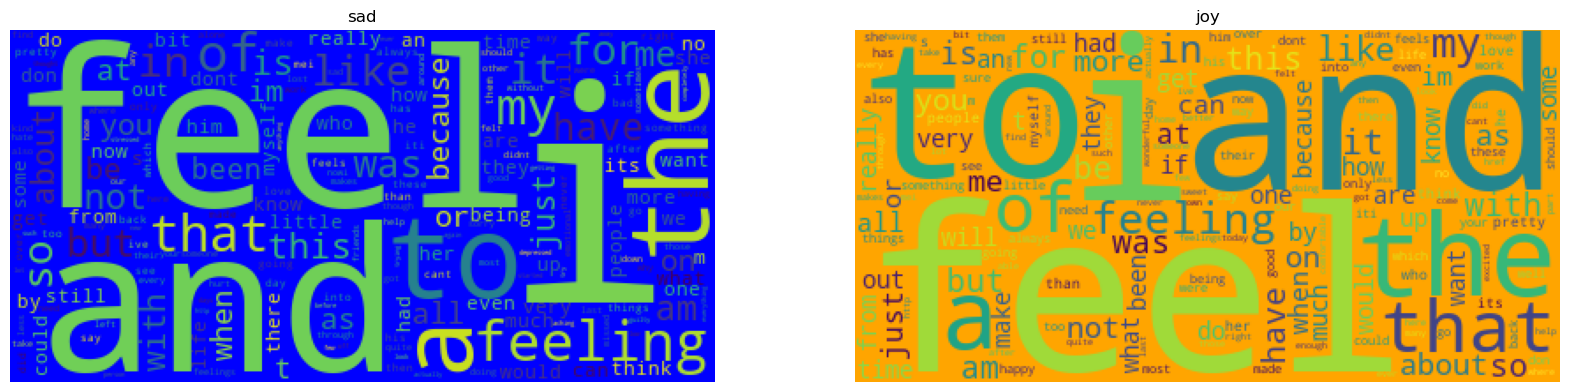

In [33]:
plt.figure(figsize= (20 , 30) ,facecolor='white')
plt.subplot(1, 2 ,1)
draw_wordcloud(sadness_freq , "sad" , "blue")


plt.subplot(1 , 2 , 2)
draw_wordcloud(joy_freq , "joy" , "orange")

plt.show()

# Splitting Data To Train ,Test & val

In [34]:
X = balanced_df['text']
y = balanced_df['label']

In [35]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=50)

In [36]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_val_bow = vectorizer.transform(X_val)
X_test_bow = vectorizer.transform(X_test)

# Baseline Model

## Baseline Using Sklearn

In [37]:
# Initialize DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)

In [38]:
dummy_clf.fit(X_train_bow, y_train)

DummyClassifier(random_state=42, strategy='most_frequent')

In [39]:
y_pred = dummy_clf.predict(X_val_bow)

# Print accuracy
print("Accuracy:", accuracy_score(y_val, y_pred))

# Print classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))

Accuracy: 0.17052807347109164
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2399
           1       0.00      0.00      0.00      2401
           2       0.00      0.00      0.00      2364
           3       0.00      0.00      0.00      2360
           4       0.00      0.00      0.00      2398
           5       0.17      1.00      0.29      2451

    accuracy                           0.17     14373
   macro avg       0.03      0.17      0.05     14373
weighted avg       0.03      0.17      0.05     14373



c:\Users\noams\anaconda3\envs\DeepLearningProjectNew\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\noams\anaconda3\envs\DeepLearningProjectNew\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\noams\anaconda3\envs\DeepLearningProjectNew\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

## Baseline Implementation using Pytorch

In [40]:
# Define the model as a subclass of nn.Module
class DummyModel(nn.Module):
    def __init__(self, most_frequent_class):
        super(DummyModel, self).__init__()
        # Initialize parameter for guessing
        self.most_frequent_class = most_frequent_class

    def forward(self, x):
        # Return the most frequent class for all samples
        batch_size = x.shape[0]
        return torch.full((batch_size,), self.most_frequent_class, dtype=torch.int32)

In [41]:
my_dummy = DummyModel(most_frequent_class = 1)

# Forward pass
y_pred = my_dummy(X_val_bow)
print(y_pred)  # Outputs: tensor([1, 1, 1, 1, 1])

tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32)


In [42]:
# Print accuracy
print("Accuracy:", accuracy_score(y_val, y_pred))

# Print classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))

Accuracy: 0.1670493286022403
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2399
           1       0.17      1.00      0.29      2401
           2       0.00      0.00      0.00      2364
           3       0.00      0.00      0.00      2360
           4       0.00      0.00      0.00      2398
           5       0.00      0.00      0.00      2451

    accuracy                           0.17     14373
   macro avg       0.03      0.17      0.05     14373
weighted avg       0.03      0.17      0.05     14373



c:\Users\noams\anaconda3\envs\DeepLearningProjectNew\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\noams\anaconda3\envs\DeepLearningProjectNew\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\noams\anaconda3\envs\DeepLearningProjectNew\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

# Bag Of Words Models

## Softmax No Hidden Layers

### First Try

In [43]:
#SVD- like PCA but works on Compressed Sparse Row format
num_features = 50
svd = TruncatedSVD(n_components = num_features)
# [0] svd(50)
# [0.1*21+0.2*100]
# fit only on the training data, transform on training ,validation and test data
X_train_svd = svd.fit_transform(X_train_bow)
X_val_svd = svd.transform(X_val_bow)
X_test_svd = svd.transform(X_test_bow)

X_train_svd

array([[ 0.92830647, -0.41426266,  0.55716453, ..., -0.03998939,
         0.0186882 , -0.04306362],
       [ 0.96533988, -0.46302714, -0.28107302, ..., -0.0156445 ,
        -0.15035057, -0.02043827],
       [ 2.26046221, -0.11366648,  0.18645731, ..., -0.14704195,
        -0.43314125,  0.19231883],
       ...,
       [ 0.53111971, -0.4060265 , -0.29255648, ..., -0.08663841,
         0.09735177, -0.19511047],
       [ 2.42072285,  0.49549407, -0.41349984, ..., -0.05011536,
        -0.13002248, -0.02814627],
       [ 0.43692268, -0.41497692, -0.29857097, ..., -0.01580009,
        -0.00878031, -0.01880949]])

In [44]:
X_train_svd.shape

(57492, 50)

In [45]:
y_train.shape

(57492,)

In [46]:
# # noam DELETE!
# # Split into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_svd, y, test_size=0.2, random_state=42)

# Convert train data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_svd, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)

# Convert validation data to PyTorch tensors
X_val_tensor = torch.tensor(X_val_svd, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test_svd, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

In [47]:
# Define the model as a subclass of nn.Module for a bag-of-words pre-processing
class BOWRegressionModel(nn.Module):
    def __init__(self, num_feats, num_classes):
        super(BOWRegressionModel, self).__init__()
        # Initialize linear layer
        self.linear = nn.Linear(num_feats, num_classes)  # Linear layer: Wx + b

    def forward(self, x):
        return  self.linear(x)  # Apply the linear transformation

In [48]:
# setting up schema:
    # insert: model, optimizer, loss function, num_of_features/dataset

In [49]:
##### noam part #####
import signal

# Global stop flag
stop_training = False

def handle_interrupt(signum, frame):
    """
    Set the global stop flag when Ctrl+C is pressed.
    This lets us finish the current epoch before stopping.
    """
    global stop_training
    print("\n[Interrupt] Finishing current epoch, then stopping...")
    stop_training = True

# Register our signal handler for SIGINT (Ctrl+C)
signal.signal(signal.SIGINT, handle_interrupt)

##### END noam part #####

#model = BOWRegressionModel(num_words = unique_words)
model = BOWRegressionModel(num_features, 6)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
loader = DataLoader(dataset, batch_size=100, shuffle=True)

# Loss function: Mean Squared Error for regression, Cross Entropy for multiclass
#criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

# Optimizer: Stochastic Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training the model
epochs = 30
for epoch in range(epochs):
    if stop_training:
        print(f"Stopping before epoch {epoch+1} begins.")
        break
    for batch_X, batch_y in loader:
        # Ensure target labels are in the correct format (long tensor of class indices)
        batch_y = batch_y.long().view(-1)  # Ensure batch_y is of type long (required for CrossEntropyLoss)
        
        # Forward pass
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        
        # Backward pass
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update parameters
    
    if (epoch + 1) % 10 == 0:
        print("#######################")
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
        
        # Calculate training accuracy
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            train_logits = model(X_train_tensor)
            train_preds = torch.argmax(train_logits, dim=1)
            train_accuracy = accuracy_score(y_train, train_preds)
            print(f"Training Accuracy: {train_accuracy:.4f}")

        # Calculate validation accuracy
        with torch.no_grad():
            val_logits = model(X_val_tensor)
            val_preds = torch.argmax(val_logits, dim=1)
            val_accuracy = accuracy_score(y_val, val_preds)
            print(f"Validation Accuracy: {val_accuracy:.4f}")

#######################
Epoch 10/30, Loss: 1.7487
Training Accuracy: 0.2507
Validation Accuracy: 0.2495

[Interrupt] Finishing current epoch, then stopping...
Stopping before epoch 17 begins.


In [50]:
# Prediction: pick the class with the highest logits
def predict(model, X_test_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients
        logits = model(X_test_tensor)  # Get logits
        #probabilities = torch.softmax(logits, dim=1)  # Apply softmax to get probabilities
        predicted_classes = torch.argmax(logits, dim=1)  # Choose class with the highest probability
    return predicted_classes

# Example: predicting on test data
y_pred = predict(model, X_val_tensor)

In [51]:
# Accuracy metric
accuracy = MulticlassAccuracy(num_classes=6)
print("Accuracy:", accuracy(y_pred, y_val_tensor.long().view(-1)).item())

# Confusion matrix
confusion_matrix = MulticlassConfusionMatrix(num_classes=6)
print("Confusion Matrix:\n", confusion_matrix(y_pred, y_val_tensor.long().view(-1)))

Accuracy: 0.25248146057128906
Confusion Matrix:
 tensor([[614, 279, 378, 314, 425, 389],
        [411, 570, 459, 244, 358, 359],
        [363, 413, 638, 268, 349, 333],
        [502, 295, 322, 428, 398, 415],
        [431, 305, 266, 313, 671, 412],
        [391, 299, 327, 258, 464, 712]])


### Second Try

In [52]:
#SVD- like PCA but works on Compressed Sparse Row format
num_features = 900
svd = TruncatedSVD(n_components = num_features)
# [0] svd(50)
# [0.1*21+0.2*100]
# fit only on the training data, transform on training ,validation and test data
X_train_svd = svd.fit_transform(X_train_bow)
X_val_svd = svd.transform(X_val_bow)
X_test_svd = svd.transform(X_test_bow)

X_train_svd

array([[ 9.28306469e-01, -4.14262668e-01,  5.57164543e-01, ...,
         1.16626365e-01,  1.24563435e-01,  3.54370819e-02],
       [ 9.65339879e-01, -4.63027138e-01, -2.81073028e-01, ...,
         1.00666338e-01,  9.68996478e-03,  5.76718958e-02],
       [ 2.26046221e+00, -1.13666530e-01,  1.86457342e-01, ...,
         2.36584481e-02, -6.86840887e-02, -2.93901349e-02],
       ...,
       [ 5.31119714e-01, -4.06026482e-01, -2.92556572e-01, ...,
        -4.94852093e-03,  4.52689954e-03, -8.85290206e-04],
       [ 2.42072285e+00,  4.95494060e-01, -4.13499803e-01, ...,
         9.51276644e-03, -5.61539909e-02,  2.31847879e-02],
       [ 4.36922684e-01, -4.14976923e-01, -2.98570965e-01, ...,
         6.37279048e-02, -5.76612618e-02, -1.09255594e-02]])

In [53]:
# Convert train data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_svd, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)

# Convert validation data to PyTorch tensors
X_val_tensor = torch.tensor(X_val_svd, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test_svd, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

In [54]:
# Define the model as a subclass of nn.Module for a bag-of-words pre-processing
class BOWRegressionModel(nn.Module):
    def __init__(self, num_feats, num_classes):
        super(BOWRegressionModel, self).__init__()
        # Initialize linear layer
        self.linear = nn.Linear(num_feats, num_classes)  # Linear layer: Wx + b

    def forward(self, x):
        return  self.linear(x)  # Apply the linear transformation

In [56]:
##### noam part #####
import signal

# Global stop flag
stop_training = False

def handle_interrupt(signum, frame):
    """
    Set the global stop flag when Ctrl+C is pressed.
    This lets us finish the current epoch before stopping.
    """
    global stop_training
    print("\n[Interrupt] Finishing current epoch, then stopping...")
    stop_training = True

# Register our signal handler for SIGINT (Ctrl+C)
signal.signal(signal.SIGINT, handle_interrupt)

##### END noam part #####

#model = BOWRegressionModel(num_words = unique_words)
model = BOWRegressionModel(num_features, 6)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
loader = DataLoader(dataset, batch_size=100, shuffle=True)

# Loss function: Mean Squared Error for regression, Cross Entropy for multiclass
#criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

# Optimizer: Stochastic Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training the model
epochs = 100
for epoch in range(epochs):
    if stop_training:
        print(f"Stopping before epoch {epoch+1} begins.")
        break
    for batch_X, batch_y in loader:
        # Ensure target labels are in the correct format (long tensor of class indices)
        batch_y = batch_y.long().view(-1)  # Ensure batch_y is of type long (required for CrossEntropyLoss)
        
        # Forward pass
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        
        # Backward pass
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update parameters
    
    if (epoch + 1) % 10 == 0:
        print("#######################")
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
        
        # Calculate training accuracy
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            train_logits = model(X_train_tensor)
            train_preds = torch.argmax(train_logits, dim=1)
            train_accuracy = accuracy_score(y_train, train_preds)
            print(f"Training Accuracy: {train_accuracy:.4f}")

        # Calculate validation accuracy
        with torch.no_grad():
            val_logits = model(X_val_tensor)
            val_preds = torch.argmax(val_logits, dim=1)
            val_accuracy = accuracy_score(y_val, val_preds)
            print(f"Validation Accuracy: {val_accuracy:.4f}")

#######################
Epoch 10/100, Loss: 0.4192
Training Accuracy: 0.8793
Validation Accuracy: 0.8549
#######################
Epoch 20/100, Loss: 0.2920
Training Accuracy: 0.8825
Validation Accuracy: 0.8576
#######################
Epoch 30/100, Loss: 0.5580
Training Accuracy: 0.8832
Validation Accuracy: 0.8544
#######################
Epoch 40/100, Loss: 0.3363
Training Accuracy: 0.8821
Validation Accuracy: 0.8531
#######################
Epoch 50/100, Loss: 0.4329
Training Accuracy: 0.8820
Validation Accuracy: 0.8491
#######################
Epoch 60/100, Loss: 0.3497
Training Accuracy: 0.8832
Validation Accuracy: 0.8517

[Interrupt] Finishing current epoch, then stopping...
Stopping before epoch 69 begins.


In [57]:
# Prediction: pick the class with the highest logits
def predict(model, X_test_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients
        logits = model(X_test_tensor)  # Get logits
        #probabilities = torch.softmax(logits, dim=1)  # Apply softmax to get probabilities
        predicted_classes = torch.argmax(logits, dim=1)  # Choose class with the highest probability
    return predicted_classes

# Example: predicting on test data
y_pred = predict(model, X_val_tensor)

In [58]:
# Accuracy metric
accuracy = MulticlassAccuracy(num_classes=6)
print("Accuracy:", accuracy(y_pred, y_val_tensor.long().view(-1)).item())

# Confusion matrix
confusion_matrix = MulticlassConfusionMatrix(num_classes=6)
print("Confusion Matrix:\n", confusion_matrix(y_pred, y_val_tensor.long().view(-1)))

Accuracy: 0.8554547429084778
Confusion Matrix:
 tensor([[1985,  196,   35,   97,   69,   17],
        [ 202, 1888,  190,   33,   48,   40],
        [  35,  119, 2176,   14,    7,   13],
        [ 163,  116,   11, 1983,   80,    7],
        [  87,   81,   12,   72, 1965,  181],
        [  17,   21,    9,   15,   88, 2301]])


### Third Try

In [59]:
#SVD- like PCA but works on Compressed Sparse Row format
num_features = 1200
svd = TruncatedSVD(n_components = num_features)
# [0] svd(50)
# [0.1*21+0.2*100]
# fit only on the training data, transform on training ,validation and test data
X_train_svd = svd.fit_transform(X_train_bow)
X_val_svd = svd.transform(X_val_bow)
X_test_svd = svd.transform(X_test_bow)

X_train_svd

array([[ 9.28306469e-01, -4.14262668e-01,  5.57164543e-01, ...,
         6.89021025e-02, -2.51779919e-02, -2.48483495e-02],
       [ 9.65339879e-01, -4.63027138e-01, -2.81073028e-01, ...,
         2.16019714e-02, -3.79428638e-03, -2.62476944e-02],
       [ 2.26046221e+00, -1.13666530e-01,  1.86457342e-01, ...,
         1.01933775e-04, -4.24884756e-03,  8.70698227e-03],
       ...,
       [ 5.31119714e-01, -4.06026482e-01, -2.92556572e-01, ...,
        -3.85963475e-04, -6.64770342e-04,  1.56040379e-03],
       [ 2.42072285e+00,  4.95494060e-01, -4.13499803e-01, ...,
         2.03021772e-02,  4.03136115e-02, -3.57251486e-02],
       [ 4.36922684e-01, -4.14976923e-01, -2.98570965e-01, ...,
         3.36389340e-02,  1.15176062e-01, -9.75597207e-06]])

In [60]:
# Convert train data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_svd, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)

# Convert validation data to PyTorch tensors
X_val_tensor = torch.tensor(X_val_svd, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test_svd, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

In [319]:
# Define the model as a subclass of nn.Module for a bag-of-words pre-processing
class BOWRegressionModel(nn.Module):
    def __init__(self, num_feats, num_classes):
        super(BOWRegressionModel, self).__init__()
        # Initialize linear layer
        self.linear = nn.Linear(num_feats, num_classes)  # Linear layer: Wx + b

    def forward(self, x):
        return  self.linear(x)  # Apply the linear transformation

In [62]:
##### noam part #####
import signal

# Global stop flag
stop_training = False

def handle_interrupt(signum, frame):
    """
    Set the global stop flag when Ctrl+C is pressed.
    This lets us finish the current epoch before stopping.
    """
    global stop_training
    print("\n[Interrupt] Finishing current epoch, then stopping...")
    stop_training = True

# Register our signal handler for SIGINT (Ctrl+C)
signal.signal(signal.SIGINT, handle_interrupt)

##### END noam part #####

#model = BOWRegressionModel(num_words = unique_words)
model = BOWRegressionModel(num_features, 6)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
loader = DataLoader(dataset, batch_size=100, shuffle=True)

# Loss function: Mean Squared Error for regression, Cross Entropy for multiclass
#criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

# Optimizer: Stochastic Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training the model
epochs = 100
for epoch in range(epochs):
    if stop_training:
        print(f"Stopping before epoch {epoch+1} begins.")
        break
    for batch_X, batch_y in loader:
        # Ensure target labels are in the correct format (long tensor of class indices)
        batch_y = batch_y.long().view(-1)  # Ensure batch_y is of type long (required for CrossEntropyLoss)
        
        # Forward pass
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        
        # Backward pass
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update parameters
    
    if (epoch + 1) % 10 == 0:
        print("#######################")
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
        
        # Calculate training accuracy
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            train_logits = model(X_train_tensor)
            train_preds = torch.argmax(train_logits, dim=1)
            train_accuracy = accuracy_score(y_train, train_preds)
            print(f"Training Accuracy: {train_accuracy:.4f}")

        # Calculate validation accuracy
        
        with torch.no_grad():
            val_logits = model(X_val_tensor)
            val_preds = torch.argmax(val_logits, dim=1)
            val_accuracy = accuracy_score(y_val, val_preds)
            print(f"Validation Accuracy: {val_accuracy:.4f}")

#######################
Epoch 10/100, Loss: 0.2775
Training Accuracy: 0.9175
Validation Accuracy: 0.8860
#######################
Epoch 20/100, Loss: 0.1614
Training Accuracy: 0.9174
Validation Accuracy: 0.8796
#######################
Epoch 30/100, Loss: 0.1625
Training Accuracy: 0.9201
Validation Accuracy: 0.8799
#######################
Epoch 40/100, Loss: 0.4183
Training Accuracy: 0.9210
Validation Accuracy: 0.8801
#######################
Epoch 50/100, Loss: 0.1347
Training Accuracy: 0.9218
Validation Accuracy: 0.8817
#######################
Epoch 60/100, Loss: 0.2179
Training Accuracy: 0.9227
Validation Accuracy: 0.8831
#######################
Epoch 70/100, Loss: 0.1567
Training Accuracy: 0.9219
Validation Accuracy: 0.8794
#######################
Epoch 80/100, Loss: 0.1814
Training Accuracy: 0.9221
Validation Accuracy: 0.8796
#######################
Epoch 90/100, Loss: 0.3215
Training Accuracy: 0.9216
Validation Accuracy: 0.8766
#######################
Epoch 100/100, Loss: 0.2227
Tra

In [321]:
# Prediction: pick the class with the highest logits
def predict(model, X_test_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients
        logits = model(X_test_tensor)  # Get logits
        #probabilities = torch.softmax(logits, dim=1)  # Apply softmax to get probabilities
        predicted_classes = torch.argmax(logits, dim=1)  # Choose class with the highest probability
    return predicted_classes

# Example: predicting on test data
y_pred = predict(model, X_val_tensor)

In [322]:
# Accuracy metric
accuracy = MulticlassAccuracy(num_classes=6)
print("Accuracy:", accuracy(y_pred, y_val_tensor.long().view(-1)).item())

# Confusion matrix
confusion_matrix = MulticlassConfusionMatrix(num_classes=6)
print("Confusion Matrix:\n", confusion_matrix(y_pred, y_val_tensor.long().view(-1)))

Accuracy: 0.8591364026069641
Confusion Matrix:
 tensor([[1964,  183,   48,  118,   68,   18],
        [ 209, 1845,  203,   57,   46,   41],
        [  35,   87, 2188,   22,    9,   23],
        [ 110,  109,   32, 2020,   75,   14],
        [  83,   75,   23,   81, 1948,  188],
        [  20,   16,    3,    2,   23, 2387]])


### Forth Try

In [323]:
#SVD- like PCA but works on Compressed Sparse Row format
num_features = 2000
svd = TruncatedSVD(n_components = num_features)
# [0] svd(50)
# [0.1*21+0.2*100]
# fit only on the training data, transform on training ,validation and test data
X_train_svd = svd.fit_transform(X_train_bow)
X_val_svd = svd.transform(X_val_bow)
X_test_svd = svd.transform(X_test_bow)

X_train_svd

array([[ 9.28306469e-01, -4.14262668e-01,  5.57164543e-01, ...,
         4.83333443e-02, -6.08200584e-02, -1.61739802e-03],
       [ 9.65339879e-01, -4.63027138e-01, -2.81073028e-01, ...,
        -2.46105890e-02,  1.55004571e-02, -4.79400946e-03],
       [ 2.26046221e+00, -1.13666530e-01,  1.86457342e-01, ...,
        -5.15076437e-03,  2.65820539e-02,  1.30123427e-02],
       ...,
       [ 5.31119714e-01, -4.06026482e-01, -2.92556572e-01, ...,
        -5.01934512e-04, -5.59622705e-03, -8.01978695e-03],
       [ 2.42072285e+00,  4.95494060e-01, -4.13499803e-01, ...,
         2.40886482e-02, -2.51331830e-02,  3.45015911e-03],
       [ 4.36922684e-01, -4.14976923e-01, -2.98570965e-01, ...,
         2.26869379e-03, -6.29799394e-03, -5.65952561e-03]])

In [324]:
# Convert train data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_svd, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)

# Convert validation data to PyTorch tensors
X_val_tensor = torch.tensor(X_val_svd, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test_svd, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

In [325]:
# Define the model as a subclass of nn.Module for a bag-of-words pre-processing
class BOWRegressionModel(nn.Module):
    def __init__(self, num_feats, num_classes):
        super(BOWRegressionModel, self).__init__()
        # Initialize linear layer
        self.linear = nn.Linear(num_feats, num_classes)  # Linear layer: Wx + b

    def forward(self, x):
        return  self.linear(x)  # Apply the linear transformation

In [326]:
##### noam part #####
import signal

# Global stop flag
stop_training = False

def handle_interrupt(signum, frame):
    """
    Set the global stop flag when Ctrl+C is pressed.
    This lets us finish the current epoch before stopping.
    """
    global stop_training
    print("\n[Interrupt] Finishing current epoch, then stopping...")
    stop_training = True

# Register our signal handler for SIGINT (Ctrl+C)
signal.signal(signal.SIGINT, handle_interrupt)

##### END noam part #####

#model = BOWRegressionModel(num_words = unique_words)
model = BOWRegressionModel(num_features, 6)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
loader = DataLoader(dataset, batch_size=100, shuffle=True)

# Loss function: Mean Squared Error for regression, Cross Entropy for multiclass
#criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

# Optimizer: Stochastic Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=0.01) # w -= lr * grad_loss_by_w

# Training the model
epochs = 100
for epoch in range(epochs):
    if stop_training:
        print(f"Stopping before epoch {epoch+1} begins.")
        break
    for batch_X, batch_y in loader:
        # Ensure target labels are in the correct format (long tensor of class indices)
        batch_y = batch_y.long().view(-1)  # Ensure batch_y is of type long (required for CrossEntropyLoss)
        
        # Forward pass
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        
        # Backward pass
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update parameters
    
    if (epoch + 1) % 10 == 0:
        print("#######################")
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
        
        # Calculate training accuracy
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            train_logits = model(X_train_tensor)
            train_preds = torch.argmax(train_logits, dim=1)
            train_accuracy = accuracy_score(y_train, train_preds)
            print(f"Training Accuracy: {train_accuracy:.4f}")

        # Calculate validation accuracy
        with torch.no_grad():
            val_logits = model(X_val_tensor)
            val_preds = torch.argmax(val_logits, dim=1)
            val_accuracy = accuracy_score(y_val, val_preds)
            print(f"Validation Accuracy: {val_accuracy:.4f}")

#######################
Epoch 10/100, Loss: 1.5226
Training Accuracy: 0.6166
Validation Accuracy: 0.6166
#######################
Epoch 20/100, Loss: 1.3902
Training Accuracy: 0.7262
Validation Accuracy: 0.7189
#######################
Epoch 30/100, Loss: 1.1909
Training Accuracy: 0.7853
Validation Accuracy: 0.7757
#######################
Epoch 40/100, Loss: 1.0549
Training Accuracy: 0.8218
Validation Accuracy: 0.8105
#######################
Epoch 50/100, Loss: 0.9930
Training Accuracy: 0.8438
Validation Accuracy: 0.8320
#######################
Epoch 60/100, Loss: 0.9490
Training Accuracy: 0.8590
Validation Accuracy: 0.8473
#######################
Epoch 70/100, Loss: 0.8080
Training Accuracy: 0.8685
Validation Accuracy: 0.8565
#######################
Epoch 80/100, Loss: 0.7823
Training Accuracy: 0.8759
Validation Accuracy: 0.8647
#######################
Epoch 90/100, Loss: 0.7184
Training Accuracy: 0.8813
Validation Accuracy: 0.8730
#######################
Epoch 100/100, Loss: 0.6938
Tra

In [327]:
# Prediction: pick the class with the highest logits
def predict(model, X_test_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients
        logits = model(X_test_tensor)  # Get logits
        #probabilities = torch.softmax(logits, dim=1)  # Apply softmax to get probabilities
        predicted_classes = torch.argmax(logits, dim=1)  # Choose class with the highest probability
    return predicted_classes

# Example: predicting on test data
y_pred = predict(model, X_val_tensor)

In [329]:
# Accuracy metric
accuracy = MulticlassAccuracy(num_classes=6)
print("Validation Accuracy:", accuracy(y_pred, y_val_tensor.long().view(-1)).item())

# Confusion matrix
confusion_matrix = MulticlassConfusionMatrix(num_classes=6)
print("Confusion Matrix:\n", confusion_matrix(y_pred, y_val_tensor.long().view(-1)))

Validation Accuracy: 0.8769968748092651
Confusion Matrix:
 tensor([[2029,  134,   44,  109,   65,   18],
        [ 137, 1929,  201,   53,   40,   41],
        [  35,   71, 2205,   21,    9,   23],
        [  83,   84,   30, 2075,   74,   14],
        [  67,   57,   23,   79, 1982,  190],
        [  16,   16,    3,    3,   25, 2388]])


### Five Try

In [330]:
#SVD- like PCA but works on Compressed Sparse Row format
num_features = 2000
svd = TruncatedSVD(n_components = num_features)
# [0] svd(50)
# [0.1*21+0.2*100]
# fit only on the training data, transform on training ,validation and test data
X_train_svd = svd.fit_transform(X_train_bow)
X_val_svd = svd.transform(X_val_bow)
X_test_svd = svd.transform(X_test_bow)

X_train_svd

array([[ 9.28306469e-01, -4.14262668e-01,  5.57164543e-01, ...,
         3.72526591e-02,  2.60128950e-02, -5.72670420e-02],
       [ 9.65339879e-01, -4.63027138e-01, -2.81073028e-01, ...,
        -5.90777733e-03,  7.84134627e-03,  4.65968297e-03],
       [ 2.26046221e+00, -1.13666530e-01,  1.86457342e-01, ...,
         1.15711704e-02,  2.31695321e-02,  1.10456610e-02],
       ...,
       [ 5.31119714e-01, -4.06026482e-01, -2.92556572e-01, ...,
         4.41158029e-03,  4.55053426e-03, -2.55642657e-04],
       [ 2.42072285e+00,  4.95494060e-01, -4.13499803e-01, ...,
        -5.77598752e-03,  1.17863300e-02, -2.05440637e-02],
       [ 4.36922684e-01, -4.14976923e-01, -2.98570965e-01, ...,
        -2.27157371e-02, -1.53306215e-02,  2.84759024e-02]])

In [331]:
# Convert train data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_svd, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)

# Convert validation data to PyTorch tensors
X_val_tensor = torch.tensor(X_val_svd, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test_svd, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

In [332]:
# Define the model as a subclass of nn.Module for a bag-of-words pre-processing
class BOWRegressionModel(nn.Module):
    def __init__(self, num_feats, num_classes):
        super(BOWRegressionModel, self).__init__()
        # Initialize linear layer
        self.linear = nn.Linear(num_feats, num_classes)  # Linear layer: Wx + b

    def forward(self, x):
        return  self.linear(x)  # Apply the linear transformation

In [336]:
##### noam part #####
import signal

# Global stop flag
stop_training = False

def handle_interrupt(signum, frame):
    """
    Set the global stop flag when Ctrl+C is pressed.
    This lets us finish the current epoch before stopping.
    """
    global stop_training
    print("\n[Interrupt] Finishing current epoch, then stopping...")
    stop_training = True

# Register our signal handler for SIGINT (Ctrl+C)
signal.signal(signal.SIGINT, handle_interrupt)

##### END noam part #####

#model = BOWRegressionModel(num_words = unique_words)
model = BOWRegressionModel(num_features, 6)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
loader = DataLoader(dataset, batch_size=100, shuffle=True)

# Loss function: Mean Squared Error for regression, Cross Entropy for multiclass
#criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

# Optimizer: Stochastic Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=0.01) # w -= lr * grad_loss_by_w

# Training the model
epochs = 100
for epoch in range(epochs):
    if stop_training:
        print(f"Stopping before epoch {epoch+1} begins.")
        break
    for batch_X, batch_y in loader:
        # Ensure target labels are in the correct format (long tensor of class indices)
        batch_y = batch_y.long().view(-1)  # Ensure batch_y is of type long (required for CrossEntropyLoss)
        
        # Forward pass
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        
        # Backward pass
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update parameters
    
    if (epoch + 1) % 10 == 0:
        print("#######################")
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
        
        # Calculate training accuracy
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            train_logits = model(X_train_tensor)
            train_preds = torch.argmax(train_logits, dim=1)
            train_accuracy = accuracy_score(y_train, train_preds)
            print(f"Training Accuracy: {train_accuracy:.4f}")

        # Calculate validation accuracy
        with torch.no_grad():
            val_logits = model(X_val_tensor)
            val_preds = torch.argmax(val_logits, dim=1)
            val_accuracy = accuracy_score(y_val, val_preds)
            print(f"Validation Accuracy: {val_accuracy:.4f}")

#######################
Epoch 10/100, Loss: 0.2035
Training Accuracy: 0.9465
Validation Accuracy: 0.8970

[Interrupt] Finishing current epoch, then stopping...
Stopping before epoch 13 begins.


In [347]:
# Prediction: pick the class with the highest logits
def predict(model, X_test_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients
        logits = model(X_test_tensor)  # Get logits
        #probabilities = torch.softmax(logits, dim=1)  # Apply softmax to get probabilities
        predicted_classes = torch.argmax(logits, dim=1)  # Choose class with the highest probability
    return predicted_classes

# Example: predicting on test data
y_pred = predict(model, X_val_tensor)

In [348]:
# Accuracy metric
accuracy = MulticlassAccuracy(num_classes=6)
print("Validation Accuracy:", accuracy(y_pred, y_val_tensor.long().view(-1)).item())

# Confusion matrix
confusion_matrix = MulticlassConfusionMatrix(num_classes=6)
print("Confusion Matrix:\n", confusion_matrix(y_pred, y_val_tensor.long().view(-1)))

Validation Accuracy: 0.8940565586090088
Confusion Matrix:
 tensor([[2162,   53,   20,   82,   67,   15],
        [  70, 2079,  174,   20,   24,   34],
        [  28,  117, 2177,   22,    6,   14],
        [  88,   40,   14, 2147,   65,    6],
        [  58,   20,   10,  105, 2033,  172],
        [  14,   26,   13,   14,  132, 2252]])


In [364]:
# show all sentence:
pd.set_option('display.max_colwidth', None)
# see what words it was wrong on
# get the wrong predictions
y_pred_series = pd.Series(y_pred.numpy())
y_val_reset = y_val.reset_index(drop=True)
# remove label
y_val_reset = y_val_reset.drop(columns = 'label')
print(y_val_reset)
print(y_pred_series)
# wrong_preds = X_val[y_val_reset != y_pred_series]
# print(X_val.shape)
# wrong_preds

0        2
1        1
2        4
3        5
4        2
        ..
14368    4
14369    4
14370    1
14371    3
14372    1
Name: label, Length: 14373, dtype: int64
0        2
1        1
2        4
3        5
4        2
        ..
14368    4
14369    4
14370    1
14371    3
14372    1
Length: 14373, dtype: int64


### Sixth Try

In [50]:
#SVD- like PCA but works on Compressed Sparse Row format
num_features = 1600
svd = TruncatedSVD(n_components = num_features)
# [0] svd(50)
# [0.1*21+0.2*100]
# fit only on the training data, transform on training ,validation and test data
X_train_svd = svd.fit_transform(X_train_bow)
X_val_svd = svd.transform(X_val_bow)
X_test_svd = svd.transform(X_test_bow)

X_train_svd

array([[ 9.28306469e-01, -4.14262668e-01,  5.57164543e-01, ...,
        -1.44149095e-01, -4.27672429e-02, -1.48792502e-01],
       [ 9.65339879e-01, -4.63027138e-01, -2.81073028e-01, ...,
         5.48741779e-02, -3.71048550e-02, -1.99133984e-02],
       [ 2.26046221e+00, -1.13666530e-01,  1.86457342e-01, ...,
         2.75315833e-04, -4.81045617e-03, -1.45676635e-02],
       ...,
       [ 5.31119714e-01, -4.06026482e-01, -2.92556572e-01, ...,
         8.57120459e-04, -8.39922299e-04,  2.45651837e-04],
       [ 2.42072285e+00,  4.95494060e-01, -4.13499803e-01, ...,
         1.35323295e-02,  2.67541779e-03, -2.33358324e-02],
       [ 4.36922684e-01, -4.14976923e-01, -2.98570965e-01, ...,
        -8.50959772e-03, -2.28847419e-02,  2.02661201e-02]])

In [51]:
# Convert train data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_svd, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)

# Convert validation data to PyTorch tensors
X_val_tensor = torch.tensor(X_val_svd, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test_svd, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

In [52]:
# Define the model as a subclass of nn.Module for a bag-of-words pre-processing
class BOWRegressionModel(nn.Module):
    def __init__(self, num_feats, num_classes):
        super(BOWRegressionModel, self).__init__()
        # Initialize linear layer
        self.linear = nn.Linear(num_feats, num_classes)  # Linear layer: Wx + b

    def forward(self, x):
        return  self.linear(x)  # Apply the linear transformation

In [57]:
##### noam part #####
import signal

# Global stop flag
stop_training = False

def handle_interrupt(signum, frame):
    """
    Set the global stop flag when Ctrl+C is pressed.
    This lets us finish the current epoch before stopping.
    """
    global stop_training
    print("\n[Interrupt] Finishing current epoch, then stopping...")
    stop_training = True

# Register our signal handler for SIGINT (Ctrl+C)
signal.signal(signal.SIGINT, handle_interrupt)

##### END noam part #####

#model = BOWRegressionModel(num_words = unique_words)
model = BOWRegressionModel(num_features, 6)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
loader = DataLoader(dataset, batch_size=100, shuffle=True)

# Loss function: Mean Squared Error for regression, Cross Entropy for multiclass
#criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

# Optimizer: Stochastic Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4) # w -= lr * grad_loss_by_w

# Training the model
epochs = 100
for epoch in range(epochs):
    if stop_training:
        print(f"Stopping before epoch {epoch+1} begins.")
        break
    for batch_X, batch_y in loader:
        # Ensure target labels are in the correct format (long tensor of class indices)
        batch_y = batch_y.long().view(-1)  # Ensure batch_y is of type long (required for CrossEntropyLoss)
        
        # Forward pass
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        
        # Backward pass
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update parameters
    
    if (epoch + 1) % 10 == 0:
        print("#######################")
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
        
        # Calculate training accuracy
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            train_logits = model(X_train_tensor)
            train_preds = torch.argmax(train_logits, dim=1)
            train_accuracy = accuracy_score(y_train, train_preds)
            print(f"Training Accuracy: {train_accuracy:.4f}")

        # Calculate validation accuracy
        with torch.no_grad():
            val_logits = model(X_val_tensor)
            val_preds = torch.argmax(val_logits, dim=1)
            val_accuracy = accuracy_score(y_val, val_preds)
            print(f"Validation Accuracy: {val_accuracy:.4f}")

#######################
Epoch 10/100, Loss: 0.3316
Training Accuracy: 0.9203
Validation Accuracy: 0.9025
#######################
Epoch 20/100, Loss: 0.4573
Training Accuracy: 0.9196
Validation Accuracy: 0.9037
#######################
Epoch 30/100, Loss: 0.3817
Training Accuracy: 0.9208
Validation Accuracy: 0.9031
#######################
Epoch 40/100, Loss: 0.2913
Training Accuracy: 0.9187
Validation Accuracy: 0.9022
#######################
Epoch 50/100, Loss: 0.3395
Training Accuracy: 0.9197
Validation Accuracy: 0.9033
#######################
Epoch 60/100, Loss: 0.3043
Training Accuracy: 0.9201
Validation Accuracy: 0.9035
#######################
Epoch 70/100, Loss: 0.2081
Training Accuracy: 0.9194
Validation Accuracy: 0.9032
#######################
Epoch 80/100, Loss: 0.2492
Training Accuracy: 0.9200
Validation Accuracy: 0.9050
#######################
Epoch 90/100, Loss: 0.2652
Training Accuracy: 0.9197
Validation Accuracy: 0.9039
#######################
Epoch 100/100, Loss: 0.3799
Tra

In [54]:
# Prediction: pick the class with the highest logits
def predict(model, X_test_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients
        logits = model(X_test_tensor)  # Get logits
        #probabilities = torch.softmax(logits, dim=1)  # Apply softmax to get probabilities
        predicted_classes = torch.argmax(logits, dim=1)  # Choose class with the highest probability
    return predicted_classes

# Example: predicting on test data
y_pred = predict(model, X_val_tensor)

In [55]:
# Accuracy metric
accuracy = MulticlassAccuracy(num_classes=6)
print("Validation Accuracy:", accuracy(y_pred, y_val_tensor.long().view(-1)).item())

# Confusion matrix
confusion_matrix = MulticlassConfusionMatrix(num_classes=6)
print("Confusion Matrix:\n", confusion_matrix(y_pred, y_val_tensor.long().view(-1)))

Validation Accuracy: 0.9040684700012207
Confusion Matrix:
 tensor([[2119,   74,   31,   87,   68,   20],
        [  68, 2060,  187,   23,   24,   39],
        [  22,   69, 2232,   17,    6,   18],
        [  71,   68,   19, 2111,   80,   11],
        [  35,   35,   13,   54, 2075,  186],
        [   1,    4,    4,    2,   40, 2400]])


In [56]:
# see the wrong predictions

# show all sentence:
pd.set_option('display.max_colwidth', None)

# 1. Convert y_pred (tensor) to a NumPy array
y_pred_array = y_pred.detach().cpu().numpy()

# 2. Wrap it in a Pandas Series that shares the same index as y_val
#    (this avoids shape/index misalignment issues)
y_pred_series = pd.Series(y_pred_array, index=y_val.index)

# 3. Filter rows where y_val != y_pred_series
wrong_preds = X_val[y_val != y_pred_series]

# Show the filtered rows
wrong_preds


13127    a friend told me about his cousin who is my girlfriend he said she had treated him in a mean and nasty way i was surprised because in front of other people she had always treated him in a friendly way i am very sad about it
58519                                                                                                                             in my village there was this tax collector who used to cheat people and collected more than was wanted
20316                                                      i thanked joshie relentlessly for making me feel fab we hit ran a few errands one of which was a trip to target so that ty could buy a tent for our camping trip next weekend
19741                                                                                                                                i feel no matter how convinced i am that i am all alone on this life journey of mine i am not alone
65379                              i feel just like jason bourne wit

In [82]:
# sort wrong predictions by label
wrong_preds = wrong_preds.sort_values(by='label')

TypeError: sort_values() got an unexpected keyword argument 'by'

## Fully Connected Multilayered Nueral Net

### First Try

In [365]:
#SVD- like PCA but works on Compressed Sparse Row format
num_features = 2000
svd = TruncatedSVD(n_components = num_features)
# [0] svd(50)
# [0.1*21+0.2*100]
# fit only on the training data, transform on training ,validation and test data
X_train_svd = svd.fit_transform(X_train_bow)
X_val_svd = svd.transform(X_val_bow)
X_test_svd = svd.transform(X_test_bow)

X_train_svd

array([[ 9.28306469e-01, -4.14262668e-01,  5.57164543e-01, ...,
        -6.50136046e-03,  2.88671156e-02,  6.81290111e-02],
       [ 9.65339879e-01, -4.63027138e-01, -2.81073028e-01, ...,
         1.08074308e-02, -3.90349902e-03, -3.20809501e-02],
       [ 2.26046221e+00, -1.13666530e-01,  1.86457342e-01, ...,
         1.47192759e-02, -2.49299608e-02, -9.91578142e-03],
       ...,
       [ 5.31119714e-01, -4.06026482e-01, -2.92556572e-01, ...,
        -1.05798936e-03, -8.27868233e-03, -5.25767240e-03],
       [ 2.42072285e+00,  4.95494060e-01, -4.13499803e-01, ...,
         5.89508707e-03, -7.80963338e-03, -1.45899752e-02],
       [ 4.36922684e-01, -4.14976923e-01, -2.98570965e-01, ...,
         7.06642173e-03, -1.16447249e-02, -2.35895774e-02]])

In [366]:
# Convert train data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_svd, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)

# Convert validation data to PyTorch tensors
X_val_tensor = torch.tensor(X_val_svd, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test_svd, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

In [367]:
# Define the model as a subclass of nn.Module for a bag-of-words pre-processing
class FullyConnectedModel(nn.Module):
    def __init__(self, num_feats, num_classes):
        super(FullyConnectedModel, self).__init__()
        # Initialize linear layer
        self.hidden1 = nn.Linear(num_feats, 10)  # Linear layer: Wx + b with 100 neurons
        self.hidden2 = nn.Linear(100, 60)  # Linear layer: Wx + b with 60 neurons
        self.out = nn.Linear(60, num_classes)  # Linear layer: Wx + b with 6 neurons

    def forward(self, x):
        x = torch.relu(self.hidden1(x)) # Apply hidden layer 1
        x = torch.relu(self.hidden2(x)) # Apply hidden layer 2
        return  self.out(x)  # Apply last layer to get output for each class

In [369]:
##### noam part #####
import signal

# Global stop flag
stop_training = False

def handle_interrupt(signum, frame):
    """
    Set the global stop flag when Ctrl+C is pressed.
    This lets us finish the current epoch before stopping.
    """
    global stop_training
    print("\n[Interrupt] Finishing current epoch, then stopping...")
    stop_training = True

# Register our signal handler for SIGINT (Ctrl+C)
signal.signal(signal.SIGINT, handle_interrupt)

##### END noam part #####

model = FullyConnectedModel(num_features, 6)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
loader = DataLoader(dataset, batch_size=100, shuffle=True)

# Loss function: Mean Squared Error for regression, Cross Entropy for multiclass
#criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

# Optimizer: Stochastic Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=0.01) # w -= lr * grad_loss_by_w

# Training the model
epochs = 100
for epoch in range(epochs):
    if stop_training:
        print(f"Stopping before epoch {epoch+1} begins.")
        break
    for batch_X, batch_y in loader:
        # Ensure target labels are in the correct format (long tensor of class indices)
        batch_y = batch_y.long().view(-1)  # Ensure batch_y is of type long (required for CrossEntropyLoss)
        
        # Forward pass
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        
        # Backward pass
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update parameters
    
    if (epoch + 1) % 10 == 0:
        print("#######################")
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
        
        # Calculate training accuracy
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            train_logits = model(X_train_tensor)
            train_preds = torch.argmax(train_logits, dim=1)
            train_accuracy = accuracy_score(y_train, train_preds)
            print(f"Training Accuracy: {train_accuracy:.4f}")

        # Calculate validation accuracy
        with torch.no_grad():
            val_logits = model(X_val_tensor)
            val_preds = torch.argmax(val_logits, dim=1)
            val_accuracy = accuracy_score(y_val, val_preds)
            print(f"Validation Accuracy: {val_accuracy:.4f}")

#######################
Epoch 10/100, Loss: 0.1401
Training Accuracy: 0.9584
Validation Accuracy: 0.8522
#######################
Epoch 20/100, Loss: 0.0759
Training Accuracy: 0.9761
Validation Accuracy: 0.8638
#######################
Epoch 30/100, Loss: 0.0536
Training Accuracy: 0.9756
Validation Accuracy: 0.8764
#######################
Epoch 40/100, Loss: 0.1448
Training Accuracy: 0.9810
Validation Accuracy: 0.8661
#######################
Epoch 50/100, Loss: 0.0153
Training Accuracy: 0.9806
Validation Accuracy: 0.8606
#######################
Epoch 60/100, Loss: 0.0246
Training Accuracy: 0.9806
Validation Accuracy: 0.8585
#######################
Epoch 70/100, Loss: 0.0517
Training Accuracy: 0.9789
Validation Accuracy: 0.8667

[Interrupt] Finishing current epoch, then stopping...
Stopping before epoch 72 begins.


In [ ]:
# Prediction: pick the class with the highest logits
def predict(model, X_test_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients
        logits = model(X_test_tensor)  # Get logits
        #probabilities = torch.softmax(logits, dim=1)  # Apply softmax to get probabilities
        predicted_classes = torch.argmax(logits, dim=1)  # Choose class with the highest probability
    return predicted_classes

# Example: predicting on test data
y_pred = predict(model, X_val_tensor)

In [ ]:
# Accuracy metric
accuracy = MulticlassAccuracy(num_classes=6)
print("Validation Accuracy:", accuracy(y_pred, y_val_tensor.long().view(-1)).item())

# Confusion matrix
confusion_matrix = MulticlassConfusionMatrix(num_classes=6)
print("Confusion Matrix:\n", confusion_matrix(y_pred, y_val_tensor.long().view(-1)))

Validation Accuracy: 0.8940565586090088
Confusion Matrix:
 tensor([[2162,   53,   20,   82,   67,   15],
        [  70, 2079,  174,   20,   24,   34],
        [  28,  117, 2177,   22,    6,   14],
        [  88,   40,   14, 2147,   65,    6],
        [  58,   20,   10,  105, 2033,  172],
        [  14,   26,   13,   14,  132, 2252]])


### Second Try

In [7]:
#SVD- like PCA but works on Compressed Sparse Row format
num_features = 1600
svd = TruncatedSVD(n_components = num_features)
# [0] svd(50)
# [0.1*21+0.2*100]
# fit only on the training data, transform on training ,validation and test data
X_train_svd = svd.fit_transform(X_train_bow)
X_val_svd = svd.transform(X_val_bow)
X_test_svd = svd.transform(X_test_bow)

X_train_svd

NameError: name 'X_train_bow' is not defined

In [44]:
# Convert train data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_svd, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)

# Convert validation data to PyTorch tensors
X_val_tensor = torch.tensor(X_val_svd, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test_svd, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

In [5]:
# Define the model as a subclass of nn.Module for a bag-of-words pre-processing
class FullyConnectedModel(nn.Module):
    def __init__(self, num_feats, num_classes):
        super(FullyConnectedModel, self).__init__()
        # Initialize linear layer
        self.hidden1 = nn.Linear(num_feats, 10)  # Linear layer: Wx + b with 100 neurons
        self.hidden2 = nn.Linear(10, 10)
        self.hidden3 = nn.Linear(10, 10)
        self.out = nn.Linear(10, num_classes)  # Linear layer: Wx + b with 6 neurons

    def forward(self, x):
        x = torch.relu(self.hidden1(x)) # Apply hidden layer 1
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        return  self.out(x)  # Apply last layer to get output for each class

In [6]:
##### noam part #####
import signal

# Global stop flag
stop_training = False

def handle_interrupt(signum, frame):
    """
    Set the global stop flag when Ctrl+C is pressed.
    This lets us finish the current epoch before stopping.
    """
    global stop_training
    print("\n[Interrupt] Finishing current epoch, then stopping...")
    stop_training = True

# Register our signal handler for SIGINT (Ctrl+C)
signal.signal(signal.SIGINT, handle_interrupt)

##### END noam part #####

model = FullyConnectedModel(num_features, 6)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
loader = DataLoader(dataset, batch_size=100, shuffle=True)

# Loss function: Mean Squared Error for regression, Cross Entropy for multiclass
#criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

# Optimizer: Stochastic Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2) # w -= lr * grad_loss_by_w

# Training the model
epochs = 100
for epoch in range(epochs):
    if stop_training:
        print(f"Stopping before epoch {epoch+1} begins.")
        break
    for batch_X, batch_y in loader:
        # Ensure target labels are in the correct format (long tensor of class indices)
        batch_y = batch_y.long().view(-1)  # Ensure batch_y is of type long (required for CrossEntropyLoss)
        
        # Forward pass
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        
        # Backward pass
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update parameters
    
    if (epoch + 1) % 10 == 0:
        print("#######################")
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
        
        # Calculate training accuracy
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            train_logits = model(X_train_tensor)
            train_preds = torch.argmax(train_logits, dim=1)
            train_accuracy = accuracy_score(y_train, train_preds)
            print(f"Training Accuracy: {train_accuracy:.4f}")

        # Calculate validation accuracy
        with torch.no_grad():
            val_logits = model(X_val_tensor)
            val_preds = torch.argmax(val_logits, dim=1)
            val_accuracy = accuracy_score(y_val, val_preds)
            print(f"Validation Accuracy: {val_accuracy:.4f}")

NameError: name 'num_features' is not defined

In [377]:
# Prediction: pick the class with the highest logits
def predict(model, X_test_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients
        logits = model(X_test_tensor)  # Get logits
        #probabilities = torch.softmax(logits, dim=1)  # Apply softmax to get probabilities
        predicted_classes = torch.argmax(logits, dim=1)  # Choose class with the highest probability
    return predicted_classes

# Example: predicting on test data
y_pred = predict(model, X_val_tensor)

In [378]:
# Accuracy metric
accuracy = MulticlassAccuracy(num_classes=6)
print("Validation Accuracy:", accuracy(y_pred, y_val_tensor.long().view(-1)).item())

# Confusion matrix
confusion_matrix = MulticlassConfusionMatrix(num_classes=6)
print("Confusion Matrix:\n", confusion_matrix(y_pred, y_val_tensor.long().view(-1)))

Validation Accuracy: 0.9001505374908447
Confusion Matrix:
 tensor([[2070,   80,   38,  114,   80,   17],
        [  56, 2034,  204,   30,   37,   40],
        [  23,   46, 2253,   10,   16,   16],
        [  60,   55,   24, 2086,  127,    8],
        [  27,   24,    7,   58, 2083,  199],
        [   5,    5,   13,    8,    5, 2415]])


## Best BoW Model & Evaluation

### Best Model

In [ ]:
#SVD- like PCA but works on Compressed Sparse Row format
num_features = 1600
svd = TruncatedSVD(n_components = num_features)
# [0] svd(50)
# [0.1*21+0.2*100]
# fit only on the training data, transform on training ,validation and test data
X_train_svd = svd.fit_transform(X_train_bow)
X_val_svd = svd.transform(X_val_bow)
X_test_svd = svd.transform(X_test_bow)

X_train_svd

array([[ 9.28306469e-01, -4.14262668e-01,  5.57164543e-01, ...,
        -1.44149095e-01, -4.27672429e-02, -1.48792502e-01],
       [ 9.65339879e-01, -4.63027138e-01, -2.81073028e-01, ...,
         5.48741779e-02, -3.71048550e-02, -1.99133984e-02],
       [ 2.26046221e+00, -1.13666530e-01,  1.86457342e-01, ...,
         2.75315833e-04, -4.81045617e-03, -1.45676635e-02],
       ...,
       [ 5.31119714e-01, -4.06026482e-01, -2.92556572e-01, ...,
         8.57120459e-04, -8.39922299e-04,  2.45651837e-04],
       [ 2.42072285e+00,  4.95494060e-01, -4.13499803e-01, ...,
         1.35323295e-02,  2.67541779e-03, -2.33358324e-02],
       [ 4.36922684e-01, -4.14976923e-01, -2.98570965e-01, ...,
        -8.50959772e-03, -2.28847419e-02,  2.02661201e-02]])

In [ ]:
# Convert train data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_svd, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)

# Convert validation data to PyTorch tensors
X_val_tensor = torch.tensor(X_val_svd, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test_svd, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

In [ ]:
# Define the model as a subclass of nn.Module for a bag-of-words pre-processing
class BOWRegressionModel(nn.Module):
    def __init__(self, num_feats, num_classes):
        super(BOWRegressionModel, self).__init__()
        # Initialize linear layer
        self.linear = nn.Linear(num_feats, num_classes)  # Linear layer: Wx + b

    def forward(self, x):
        return  self.linear(x)  # Apply the linear transformation

In [ ]:
##### noam part #####
import signal

# Global stop flag
stop_training = False

def handle_interrupt(signum, frame):
    """
    Set the global stop flag when Ctrl+C is pressed.
    This lets us finish the current epoch before stopping.
    """
    global stop_training
    print("\n[Interrupt] Finishing current epoch, then stopping...")
    stop_training = True

# Register our signal handler for SIGINT (Ctrl+C)
signal.signal(signal.SIGINT, handle_interrupt)

##### END noam part #####

#model = BOWRegressionModel(num_words = unique_words)
model = BOWRegressionModel(num_features, 6)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
loader = DataLoader(dataset, batch_size=100, shuffle=True)

# Loss function: Mean Squared Error for regression, Cross Entropy for multiclass
#criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

# Optimizer: Stochastic Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4) # w -= lr * grad_loss_by_w

# Training the model
epochs = 100
for epoch in range(epochs):
    if stop_training:
        print(f"Stopping before epoch {epoch+1} begins.")
        break
    for batch_X, batch_y in loader:
        # Ensure target labels are in the correct format (long tensor of class indices)
        batch_y = batch_y.long().view(-1)  # Ensure batch_y is of type long (required for CrossEntropyLoss)
        
        # Forward pass
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        
        # Backward pass
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update parameters
    
    if (epoch + 1) % 10 == 0:
        print("#######################")
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
        
        # Calculate training accuracy
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            train_logits = model(X_train_tensor)
            train_preds = torch.argmax(train_logits, dim=1)
            train_accuracy = accuracy_score(y_train, train_preds)
            print(f"Training Accuracy: {train_accuracy:.4f}")

        # Calculate validation accuracy
        with torch.no_grad():
            val_logits = model(X_val_tensor)
            val_preds = torch.argmax(val_logits, dim=1)
            val_accuracy = accuracy_score(y_val, val_preds)
            print(f"Validation Accuracy: {val_accuracy:.4f}")

#######################
Epoch 10/100, Loss: 0.3316
Training Accuracy: 0.9203
Validation Accuracy: 0.9025
#######################
Epoch 20/100, Loss: 0.4573
Training Accuracy: 0.9196
Validation Accuracy: 0.9037
#######################
Epoch 30/100, Loss: 0.3817
Training Accuracy: 0.9208
Validation Accuracy: 0.9031
#######################
Epoch 40/100, Loss: 0.2913
Training Accuracy: 0.9187
Validation Accuracy: 0.9022
#######################
Epoch 50/100, Loss: 0.3395
Training Accuracy: 0.9197
Validation Accuracy: 0.9033
#######################
Epoch 60/100, Loss: 0.3043
Training Accuracy: 0.9201
Validation Accuracy: 0.9035
#######################
Epoch 70/100, Loss: 0.2081
Training Accuracy: 0.9194
Validation Accuracy: 0.9032
#######################
Epoch 80/100, Loss: 0.2492
Training Accuracy: 0.9200
Validation Accuracy: 0.9050
#######################
Epoch 90/100, Loss: 0.2652
Training Accuracy: 0.9197
Validation Accuracy: 0.9039
#######################
Epoch 100/100, Loss: 0.3799
Tra

### Model Evaluation

In [58]:
# Prediction: pick the class with the highest logits
def predict(model, X_test_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients
        logits = model(X_test_tensor)  # Get logits
        #probabilities = torch.softmax(logits, dim=1)  # Apply softmax to get probabilities
        predicted_classes = torch.argmax(logits, dim=1)  # Choose class with the highest probability
    return predicted_classes

# Example: predicting on test data
y_pred = predict(model, X_val_tensor)

In [59]:
# Accuracy metric
accuracy = MulticlassAccuracy(num_classes=6)
print("Validation Accuracy:", accuracy(y_pred, y_val_tensor.long().view(-1)).item())

# Confusion matrix
confusion_matrix = MulticlassConfusionMatrix(num_classes=6)
print("Confusion Matrix:\n", confusion_matrix(y_pred, y_val_tensor.long().view(-1)))

Validation Accuracy: 0.904673159122467
Confusion Matrix:
 tensor([[2110,   78,   34,   86,   72,   19],
        [  58, 2061,  188,   30,   25,   39],
        [  16,   52, 2258,   15,    6,   17],
        [  79,   60,   17, 2119,   74,   11],
        [  35,   27,   15,   75, 2066,  180],
        [   2,    5,    5,    3,   45, 2391]])


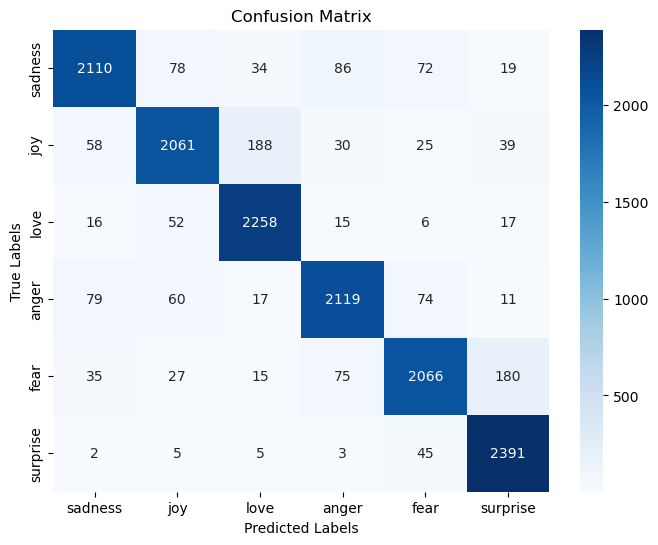

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchmetrics.classification import MulticlassAccuracy, MulticlassConfusionMatrix

cm = confusion_matrix(y_pred, y_val_tensor.long().view(-1))  # Convert to NumPy array

# Define class names
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [77]:
# see the wrong predictions

# show all sentence:
pd.set_option('display.max_colwidth', None)

# 1. Convert y_pred (tensor) to a NumPy array
y_pred_array = y_pred.detach().cpu().numpy()

# 2. Wrap it in a Pandas Series that shares the same index as y_val
#    (this avoids shape/index misalignment issues)
y_pred_series = pd.Series(y_pred_array, index=y_val.index)

# create a df which will contain the predictions and the true labels
val_data = pd.DataFrame({'text': X_val, 'label': y_val, 'pred': y_pred_series})

# convert the numeric labels to their corresponding string labels
mapping = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
val_data['label'] = val_data['label'].map(mapping)
val_data['pred'] = val_data['pred'].map(mapping)

# add word_count column
val_data['word_count'] = val_data['text'].apply(lambda x: len(x.split()))

# 3. Filter rows where y_val != y_pred_series
wrong_preds = val_data[y_val != y_pred_series]

# Show the filtered rows
wrong_preds


,text,label,pred,word_count
45860,i detested my father who was a drunkard he would rave,anger,sadness,11
13127,a friend told me about his cousin who is my girlfriend he said she had treated him in a mean and nasty way i was surprised because in front of other people she had always treated him in a friendly way i am very sad about it,sadness,surprise,47
58519,in my village there was this tax collector who used to cheat people and collected more than was wanted,anger,joy,19
20316,i thanked joshie relentlessly for making me feel fab we hit ran a few errands one of which was a trip to target so that ty could buy a tent for our camping trip next weekend,joy,sadness,36
19741,i feel no matter how convinced i am that i am all alone on this life journey of mine i am not alone,joy,sadness,23
...,...,...,...,...
36015,im nervous but feeling passionate,love,fear,5
29985,im pretty sure that feeling is mutual for her too such a sweet pair,love,joy,14
51833,finding out that old and useless practitioners of retirement age will go to your english lectures and they do not understand english,anger,sadness,22
45414,when mix was coming from column for several days,anger,sadness,9


In [78]:
# sort wrong predictions by label
wrong_preds.sort_values(by='label')

,text,label,pred,word_count
45860,i detested my father who was a drunkard he would rave,anger,sadness,11
53106,i have felt myself feeling resentful at the limitations of my time and energies that caring for her has required,anger,love,20
56967,im still feeling that grogginess in my throat and unfortunately a cold coming on but so far this looks like the calm before the storm of sneezing coughing etc etc,anger,joy,30
52129,i showed a moment of weakness and it was fastened upon and i was made to feel like a vile person for feeling that way,anger,joy,25
45341,i feel just too vicious and too cool day a href http www,anger,joy,13
...,...,...,...,...
84872,i dont know but whenever i think about these things i get so many mixed feelings shocked angry resentful and then i get really really confused about whether or not i should be with him,surprise,anger,35
88054,i end up feeling overwhelmed and anxious about responding to comments and reading enough to write that much,surprise,fear,18
89455,i worry and wonder and laugh about there s a world of others out there who have been waiting to hear someone else admit to what you re admitting and they are so overjoyed to find that little connection with another person especially if it s something they ve been feeling strange or insecure about,surprise,fear,55
85575,i blinked a couple of times trying to come back to reality because looking at him made me feel a little weird inside,surprise,fear,23


In [109]:
# getting 50 random texts without thier label - to check if a human can classify them from the wrong_preds
random_texts = wrong_preds.sample(50)
# reset the index of the random texts
random_texts = random_texts.reset_index(drop=True)
random_texts['text']
# get the true labels for the random texts
# random_labels = y_val.loc[random_texts.index]


0                                                                                                                                                                                                         seeing relations from overseas after a few years
1           i was feeling depressed or frustrated about my lot in life all i had to do was tap the player one button and my worries would instantly slip away as my mind focused itself on the relentless pixelated onslaught on the screen in front of me
2                                                                                                                                                                                                i feel like im still in a bit of a weird in between phase
3                                                                                                                                                                                         i hadnt seen him in over a week so he was feeling pretty amor

In [110]:
random_texts[['text', 'label', 'pred']]

,text,label,pred
0,seeing relations from overseas after a few years,joy,sadness
1,i was feeling depressed or frustrated about my lot in life all i had to do was tap the player one button and my worries would instantly slip away as my mind focused itself on the relentless pixelated onslaught on the screen in front of me,sadness,anger
2,i feel like im still in a bit of a weird in between phase,fear,surprise
3,i hadnt seen him in over a week so he was feeling pretty amorous,love,joy
4,i guess i need to figure out how i can tackle all these things without feeling so overwhelmed,fear,surprise
5,i have to project the cowboy way probably stems directly from my uncle arthur certainly my ability to not feel absolutety ludicrous in a cowboy hat and boots,sadness,surprise
6,i feel like ive been assaulted i said and i paid for it,sadness,fear
7,i dont feel like doing that again because mama rabbit got really ferocious and started running away hence scratching me,anger,joy
8,i started to feel weird mid back pain,fear,surprise
9,i think i still get that feeling sometimes when it snows despite the fact that i am not very fond of the cold,love,anger


In [121]:
# get human predictions from emotion_text_labels.csv
human_preds = pd.read_csv('emotion_text_labels.csv')
print(human_preds.head())

# print the unique values in the 'label' column
print(human_preds['Label'].unique())

                                                                                                                                                                                                                                             Text  \
0                                                                                                                                                                                                seeing relations from overseas after a few years   
1  i was feeling depressed or frustrated about my lot in life all i had to do was tap the player one button and my worries would instantly slip away as my mind focused itself on the relentless pixelated onslaught on the screen in front of me   
2                                                                                                                                                                                       i feel like im still in a bit of a weird in between phase   
3                   

In [122]:
# from each row - take only the first word in the 'Label' column. remove even / and ?
# Handle NaN values and apply the transformation
human_preds['Label'] = human_preds['Label'].fillna('').apply(lambda x: x.split()[0].split('/')[0].replace('/', '').replace('?', '') if x else '')
human_preds['Label'].unique()

array(['love', 'sadness', 'fear', 'joy', 'anger', 'surprise',
       'considerate', ''], dtype=object)

In [127]:
human_preds[human_preds['Label'] == 'considerate']['Label']

31    considerate
Name: Label, dtype: object

In [129]:
# human_preds.loc[human_preds['Label'] == 'considerate', 'Label'] = ''
human_preds.iloc[31]['Label']

''

In [130]:
human_preds['Label'].unique()

array(['love', 'sadness', 'fear', 'joy', 'anger', 'surprise', ''],
      dtype=object)

In [134]:
human_preds.head()

,Text,Label
0,seeing relations from overseas after a few years,love
1,i was feeling depressed or frustrated about my lot in life all i had to do was tap the player one button and my worries would instantly slip away as my mind focused itself on the relentless pixelated onslaught on the screen in front of me,sadness
2,i feel like im still in a bit of a weird in between phase,sadness
3,i hadnt seen him in over a week so he was feeling pretty amorous,love
4,i guess i need to figure out how i can tackle all these things without feeling so overwhelmed,fear


In [135]:
human_preds["Label"]

0         love
1      sadness
2      sadness
3         love
4         fear
5          joy
6        anger
7         fear
8         fear
9          joy
10    surprise
11        love
12       anger
13     sadness
14     sadness
15     sadness
16       anger
17    surprise
18        fear
19        love
20        love
21       anger
22         joy
23         joy
24     sadness
25         joy
26     sadness
27        love
28     sadness
29     sadness
30     sadness
31            
32    surprise
33       anger
34        love
35        fear
36        love
37     sadness
38            
39     sadness
40       anger
41         joy
42       anger
43     sadness
44         joy
45            
46            
47        love
48    surprise
49        love
50            
Name: Label, dtype: object

In [145]:
# concat the human results to the val_data  
random_texts['human_pred'] = human_preds['Label']
# show were the human prediction is different from the label
print(random_texts[random_texts['label'] != random_texts['human_pred']][['text', 'pred', 'label', 'human_pred']].shape)
random_texts[random_texts['label'] != random_texts['human_pred']][['text', 'pred', 'label', 'human_pred']]

(34, 4)


,text,pred,label,human_pred
0,seeing relations from overseas after a few years,sadness,joy,love
2,i feel like im still in a bit of a weird in between phase,surprise,fear,sadness
5,i have to project the cowboy way probably stems directly from my uncle arthur certainly my ability to not feel absolutety ludicrous in a cowboy hat and boots,surprise,sadness,joy
6,i feel like ive been assaulted i said and i paid for it,fear,sadness,anger
7,i dont feel like doing that again because mama rabbit got really ferocious and started running away hence scratching me,joy,anger,fear
9,i think i still get that feeling sometimes when it snows despite the fact that i am not very fond of the cold,anger,love,joy
10,i just have to say that the entire ordeal just left me feeling amused slightly annoyed and more than a little confused,anger,joy,surprise
11,im feeling a strange kinship with abrahams sarah,surprise,fear,love
14,i am feeling extremely loney and agitated,anger,fear,sadness
17,i feel strange in my life though,surprise,fear,surprise


In [79]:
# Calculate statistics
min_words = wrong_preds['word_count'].min()
max_words = wrong_preds['word_count'].max()
avg_words = wrong_preds['word_count'].mean()

print(f"Minimum words: {min_words}")
print(f"Maximum words: {max_words}")
print(f"Average words: {avg_words:.2f}")

Minimum words: 2
Maximum words: 65
Average words: 21.60


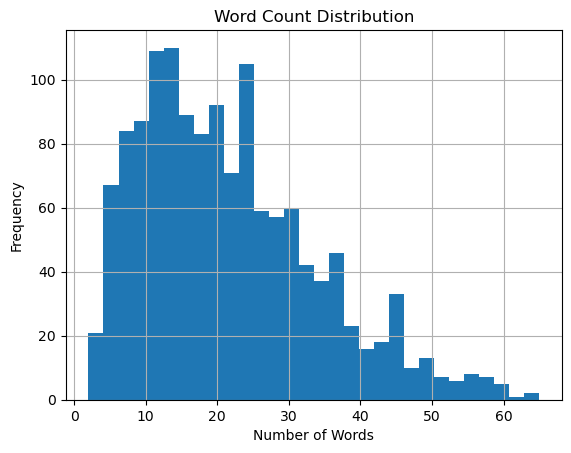

In [80]:
wrong_preds['word_count'].hist(bins=30)
plt.title("Word Count Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

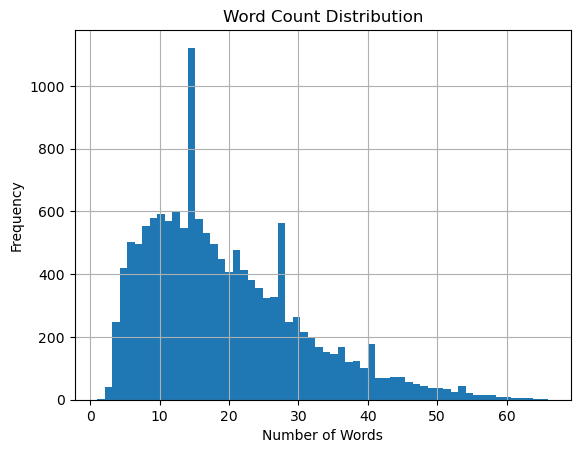

In [91]:
val_data['word_count'].hist(bins=60)
plt.title("Word Count Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# Word embedding- Word2Vec

In [201]:
# Tokenize sentences into words
sentences = balanced_df['text'].apply(lambda x: x.split())

# Train a Word2Vec model on your dataset
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Function to compute the average Word2Vec vector for a sentence
def sentence_to_vector(sentence, model, vector_size):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(vector_size)  # Return a zero vector for empty or OOV sentences

In [202]:
vector_size = word2vec_model.vector_size
X = np.array(balanced_df['text'].apply(lambda x: sentence_to_vector(x, word2vec_model, vector_size)).tolist())

In [68]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)  # Reshape labels for PyTorch

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

In [69]:
#model = BOWRegressionModel(num_words = unique_words)
model = FullyConnectedModel(vector_size, 6)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
loader = DataLoader(dataset, batch_size=100, shuffle=True)

# Loss function: Cross Entropy for multiclass
criterion = nn.CrossEntropyLoss()

# Optimizer: Stochastic Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training the model
epochs = 100
for epoch in range(epochs):
    for batch_X, batch_y in loader:
        # Ensure target labels are in the correct format (long tensor of class indices)
        batch_y = batch_y.long().view(-1)  # Ensure batch_y is of type long (required for CrossEntropyLoss)
        
        # Forward pass
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        
        # Backward pass
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update parameters
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 10/100, Loss: 1.5354
Epoch 20/100, Loss: 1.3834
Epoch 30/100, Loss: 1.3409
Epoch 40/100, Loss: 1.3863
Epoch 50/100, Loss: 1.1466
Epoch 60/100, Loss: 1.2817
Epoch 70/100, Loss: 1.0846
Epoch 80/100, Loss: 1.2464
Epoch 90/100, Loss: 0.9943
Epoch 100/100, Loss: 1.2568


In [70]:
# Example: predicting on test data
y_pred = predict(model, X_test_tensor)

# Accuracy metric
accuracy = MulticlassAccuracy(num_classes=6)
print("Accuracy:", accuracy(y_pred, y_test_tensor.long().view(-1)).item())

# Confusion matrix
confusion_matrix = MulticlassConfusionMatrix(num_classes=6)
print("Confusion Matrix:\n", confusion_matrix(y_pred, y_test_tensor.long().view(-1)))

Accuracy: 0.508057713508606
Confusion Matrix:
 tensor([[ 895,  723,  486,  565,  199,  112],
        [ 365, 1489,  628,  243,  105,  131],
        [  74,  306, 2058,  263,  141,  273],
        [ 236,  309,  588, 1187,  400,  261],
        [ 213,  184,  474,  615,  944,  664],
        [  12,   38,  149,   64,   74, 2499]])


# FastText Word Embeddings

In [ ]:
# LOADING THE MODEL

import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from tqdm import tqdm


# Load pre-trained FastText vectors
fasttext_path = "cc.en.300.vec"
fasttext = KeyedVectors.load_word2vec_format(fasttext_path, binary=False)

# Check an example word vector
print(fasttext['happy'])  # Output: [0.1, -0.3, ...] (300-dimensional vector)

In [55]:
import re
from nltk.tokenize import word_tokenize

def preprocess_text(text):
    text = text.lower()  # Lowercase the text
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic characters
    return word_tokenize(text)

# Apply preprocessing to the text column
# balanced_df['tokenized_text'] = balanced_df['text'].apply(preprocess_text)
balanced_df.iloc[89831]['tokenized_text']

['i',
 'ask',
 'him',
 'feeling',
 'like',
 'im',
 'interviewing',
 'him',
 'but',
 'im',
 'curious',
 'about',
 'him',
 'yeah',
 'just',
 'up',
 'that',
 'hill']

In [ ]:
# import nltk
# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import wordnet

# nltk.download('averaged_perceptron_tagger_eng')
# nltk.download('wordnet')

# lemmatizer = WordNetLemmatizer()

# def get_wordnet_pos(tag):
#     """Map POS tag to format expected by WordNetLemmatizer."""
#     if tag.startswith('J'):
#         return wordnet.ADJ
#     elif tag.startswith('V'):
#         return wordnet.VERB
#     elif tag.startswith('N'):
#         return wordnet.NOUN
#     elif tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return wordnet.NOUN  # Default to noun

# def preprocess_text_with_pos(text):
#     tokens = nltk.word_tokenize(text.lower())
#     pos_tags = nltk.pos_tag(tokens)  # Get POS tags
#     lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
#     return lemmatized_tokens

# # Example usage
# sample_text = "Im feeling like I'm interviewing him."
# print(preprocess_text_with_pos(sample_text))


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\noams\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\noams\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['im', 'feeling', 'like', 'i', "'m", 'interview', 'him', '.']


In [56]:
def sentence_to_vector(sentence, fasttext, embedding_dim=300):
    vectors = [fasttext[word] for word in sentence if word in fasttext]
    if len(vectors) == 0:
        return np.zeros(embedding_dim)  # Handle empty sentence case
    return np.mean(vectors, axis=0)

# Apply sentence vectorization
balanced_df['vector'] = balanced_df['tokenized_text'].apply(lambda x: sentence_to_vector(x, fasttext))
# X = np.stack(balanced_df['vector'].values)  # Create feature matrix
# y = balanced_df['label'].values  # Sentiment labels
balanced_df

NameError: name 'fasttext' is not defined